# Probabilitstic modelling

This new notebook will use the same description for all processes (classical Boltzmann-Gibbs equilibrium, Sample-Space Reducing processes, Bouchaud-Mézard processes) than the previous one [ref]. Rather than simulating an agent in a particular state and its jumps between states, only the distribution of states will be described (as it is in a quantum state), with its evolution.

> fig : 1/ state(t) = i, tirage v.a. X = (new_state, jump_time) --> state(t+jump_time) = new_state
>          loi de v.a. X --> lois exp paramètres 'taux de transition' (dim=temps**-1)
>       2/ state(t) = [a1, a2, ..., ad], state(t+dt) = state(t) + Mat.dot(state(t))*dt
>          master equation

This enables us to use the same description for all upcited models, as well as using non-renormalized states (where the matrix is not stochastic any more, and the total density is more than 1). This is usefull for modelling the BM model as well as variants of the canonical SSR process, and corresponds to probability 'sources' and 'sinks'.

> Ex : ajouter du bruit --> norme(state) = exp((m+sgm2)t)

Our framework is still the modelling of wealth exchange and inequality among a population.

## General description

### Formally

All models will rely on the same general description.
We will study the distribution of a certain quantity $x$ over a finite number of (macro)states $0, 1, 2, ..., D-1$, and its dynamics. The density vector obeys to a simple first-order linear differential equation, corresponding to the evolution of a Markovian system :
$$\forall \, i \in \lbrace 0, 1, ..., D-1 \rbrace, \qquad \dfrac{\mathrm{d}x_{i}}{\mathrm{d}t} = \sum_{j=0}^{D-1} J_{ij}x_{j}$$
This defines the *master equation* for $\mathbf{X} = (x_i)_{0 \, \leqslant \, i \, < D}$ and $\mathbf{J} = (J_{ij})_{0 \, \leqslant \, i,j \, < \, D}$ reading :
$$\dfrac{\mathrm{d}\mathbf{X}(t)}{\mathrm{d}t} = \mathbf{J}(t)\mathbf{X}(t)$$
Here the state is not normalized and no longer represents the density of state of a single-particle), and the matrix $\mathbf{J}$ is not always stochastic. Also, it is important to note that *both* $\mathbf{X}$ *and* $\mathbf{J}$ are dependant of time : $\mathbf{J}$ can have a noisy component for instance :
$$\mathbf{J}(t) = \mathbf{J_0} + \mathbf{\Xi}(t)$$

### Implementation

We will have the following correspondance for variable names :
- `float x` will be a component $x_i(t)$ of a state in the eigenbasis, 
- `ndarray state` will be the current (macro)state of the particle $\mathbf{X}(t)$,
- `ndarray states` will be the whole time-dependant state $\mathbf{X}$ (a function of time),
- `int dim` will be the number of dimensions $D$, `int i` and `int j` will be indexes refering to the dimension ($0 \, \leqslant \, i,j \, < D$), 
- `int t` will be an index refering to the time coordinate and be comprised in the timeframe $[0 \,, \, T[$ (time horizon `int T`),
- `ndarray J_0` will be the static component $\mathbf{J_0}$ of the driving matrix and `ndarray J` will be the full time-dependant matrix $\mathbf{J}(t)$. Its values at all time $t$ will not be stored,
- `ndarray xi` will be the random and time-dependant component $\mathbf{\Xi}(t)$ of the driving matrix, and `ndarray xis` will be the whole time-varying function $\mathbf{\Xi}$ associated to it,
- ...

## The models

### The canonical ensemble

Lets consider a system of a large number of particles in a box where $D$ energy levels are accessible, at temperature $T$ (`float temp`).

A macrostate of the system can be characterized by the (relative) number of particles in each state $i$ at time $t$ :
$$\forall \, i \in \lbrace 0, ..., D-1 \rbrace, \qquad x_i(t) = \dfrac{\text{# of particles in state }i}{\text{# of particles}}$$
The system will be characterized by its master equation :
$$\forall \, i \in \lbrace 0, ..., D-1 \rbrace, \qquad \dfrac{\mathrm{d}x_{i}(t)}{\mathrm{d}t} = \sum_{j\neq i} J_{ij}(t)x_{j}(t) - \sum_{j\neq i} J_{ji}(t)x_{i}(t)$$

Out-of-equilibrium, the system will behave in a complicated manner where each transition rate $J_{ij}(t)$ is not clearly defined, and is mainly driven by the precise interactions of each particles (is a function of $(\text{# of particles}) \times D$ parameters).

However, at equilibrium the precise distribution of particles in each state $i$ is know, it the *Boltzmann distribution* :
$$\forall \, i \in \lbrace 0, ..., D-1 \rbrace, \qquad x_i(t) = \frac{1}{Z}\exp\left(-\dfrac{E(i)}{k_B T}\right)$$
This distribution is *stationnary*. The transition rates are deduced from the detailed balance :
$$\forall \, i,j \in \lbrace 0, ..., D-1 \rbrace, i\neq j, \qquad J_{ij}x_j = J_{ji}x_i$$
With the stochastic condition giving :
$$\forall \, i \in \lbrace 0, ..., D-1 \rbrace, \qquad J_{ii} = - \sum_{j\neq i} J_{ji}$$

Note : it is important to know that the transition rates $J_ij$ are arbitrary : thermal equilibrium can be reached in any state for any kind of *diffusive part* of the dynamic (upper part of $\mathbf{J}).

### The canonical sample-space reducing (SSR) process

to do

### The Bouchaud-Mézard model for wealth exchange

to do

## The code

Imports :

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plt.colorbar axes positionning
import matplotlib.animation as animation

A `buildMatrix` function that encapsulate the dynamic-modelling steps :

In [3]:
def buildMatrix(dim=10, dyn='uni', param=1.) :
    """builds a stochastic matrix, corresponding to the specified dynamic (with kwarg. 'dyn')
        uni --> uniformly in [0, 1[
        mfd --> mean field (all coef. equal to param/n_states, "param" is equivalent to "J")
        bin --> binomial (1 sample with probability param)
        pow --> power-tail law (Pareto here)
        nrm --> normal law
        ssr --> ssr process (with state no <-> energy)
        BGe --> Boltzmann-Gibbs equilibrium"""
    matrix = np.zeros((dim,dim), dtype=float)
    for j in range(dim) :
        s = 0
        for i in range(dim) :
            rate = 0.
            if   dyn=='mfd' : rate = param/dim
            elif dyn=='uni' : rate = np.random.uniform()
            elif dyn=='bin' : rate = np.random.binomial(1,param)
            elif dyn=='pow' : rate = np.random.pareto(param)
            elif dyn=='nrm' : rate = np.abs(np.random.normal()) # ! the coefficients must be postive !
            elif dyn=='ssr' :
                if i<j : rate = 1/j
                elif (i==dim-1 and j==0) : rate=1
            elif dyn=='BGe' : print('ERROR buildMatrix : dyn BGe not done yet')
            else :
                print('DynamicalRule.initialize ERROR : unknown distribution, uniform used instead\n Reminder :\n    uni --> uniformly in [0, 1[\n    bin --> binomial (1 sample)\n    pow --> power-tail law (Pareto here)\n    nrm --> normal law')
                rate = np.random.uniform()
            matrix[i,j] = rate
            if i != j : s += rate
        matrix[j,j] = - s # s is the sum of all other transition rates : the matrix is thus stochastic
    return matrix

A class that defines a dynamical system with a macrostate distribution function and a master equation :
$$\forall \, i \in \lbrace 0, ..., D-1 \rbrace, \qquad \dfrac{\mathrm{d}x_{i}(t)}{\mathrm{d}t} = \sum_{j\neq i} J_{ij}(t)x_{j}(t) - \sum_{j\neq i} J_{ji}(t)x_{i}(t)$$

The class `System` will contain :
- `int System.t` the current at which the system is located (start time is by default $0$),
- `int System.T` the max time,
- `int System.dim` the number of macrostates that exists (the number of *dimensions* of the phase-space,
- `ndarray System.state` the distribution over the macrostates (`dim` coordinates),
- `ndarray System.states` the stored values of this state for all timestep from beginning of simulation to current time,
- `str System.dyn` a string indicating the dynamic, to be input in the `buildMatrix` function,
- `bool System.noisy` which indicates if the dynamic needs to call the `System.noise` function,
- `ndarray System.J_0` the constant component of the matrix corresponding to the master equation,
- `function System.noise` the function generating the random process eventually added to the driving matrix,
- `ndarray System.xi` the value taken by the random process at each timestep (vector value),
- `ndarray System.xis` the stored values of the random process,
- `dict System.analysis` a collection of all calculated data from this system,
- ...

In [8]:
class System:
    """defines a dynamical system with a macrostate distribution function and a first-order linear master equation"""
    
    def __init__(self) :
        self.t = 0
        self.T = 100
        self.dim = 5
        self.state = np.zeros(self.dim, dtype='float')
        self.state[0] += 1.
        self.states = np.zeros((self.dim, self.T))
        self.states[:,0] = self.state # storage
        self.dyn = 'ssr'
        self.noisy = False
        self.J_0 = buildMatrix(dim=self.dim, dyn=self.dyn, param=1.)
        self.noise = lambda : np.zeros((self.dim, self.dim))
        self.xi = np.zeros((self.dim, self.dim))
        self.xis = np.zeros((self.dim, self.dim, self.T)) # storage
        self.analysis = dict()
        return
    
    def reset(self) :
        """erases all storage variables as well as System.state"""
        self.t = 0
        self.state = np.zeros(self.dim, dtype='float')
        self.state[0] += 1.
        self.states = np.zeros((self.dim, self.T))
        self.states[:,0] = self.state # storage
        self.xi = np.zeros((self.dim, self.dim))
        self.xis = np.zeros((self.dim, self.dim, self.T)) # storage
        self.analysis = dict()
        return
    
    def doStep(self) :
        if self.noisy :
            self.xi = self.noise()
            self.xis[:,:,self.t] = self.xi # storage
            J = self.J_0 + self.xi
        else :
            J = self.J_0
        self.state += np.dot(J, self.state) # here dt = 1.
        self.states[:,self.t] = self.state # storage
        self.t += 1
        return
    
    def run(self) :
        self.t = 1
        while self.t < self.T :
            self.doStep()
        return
    
    def plotState(self, log=False) :
        """plots the current state (from self.state)"""
        Xs = np.arange(self.dim)
        wdth = np.zeros(self.dim)+0.5
        # setting an eventual log scale
        if log :
            Xs += 1
            plt.xscale('log')
            plt.yscale('log')
            wdth = 0.05*Xs
        # plotting
        plt.bar(Xs, self.state, width=wdth)
        plt.xlabel('state coordinates')
        plt.ylabel('density (not norm.)')
        # placing ticks on axes
        if self.dim <= 15 and not log :
            plt.xticks(Xs)
        plt.show()
        return
    
    def animateState(self, log=False) :
        """plots all the states stored in self.states in an animation"""
        fig = plt.figure()
        Xs = np.arange(self.dim)
        wdth = np.zeros(self.dim)+0.5
        # setting an eventual log scale
        if log :
            Xs += 1
            plt.xscale('log')
            plt.yscale('log')
            wdth = 0.05*Xs
        # plotting
        mean = np.sum(self.state)/self.dim
        bars = plt.bar(Xs, self.state/mean, width=wdth)
        txt = plt.text(0.5*self.dim, 1, '')
        plt.xlabel('state coordinates')
        plt.ylabel('density (not norm.)')
        # placing ticks on axes
        if self.dim <= 15 and not log :
            plt.xticks(Xs)

        def animate(t, syst) :
            #if t >= self.T :
            #    print('WARNING - System.animateState() loc. fct. animate() : index t out of range (%d >= %d)'%(t,self.T))
            #    return
            t = t%syst.T
            print(t)
            state = syst.states[:,t]
            mean = np.sum(state)/self.dim
            for i in range(self.dim) :
                bars[i].set_height(state[i]/mean)
            txt.set_text('t = '+str(t))
            return bars.patches + [txt]

        # tests
        #print(type(txt), txt)
        #print(type(bars), bars)
        #print(type(bars.patches), bars.patches)
        global ani
        
        ani = animation.FuncAnimation(fig, animate, fargs=(self,), interval=200, blit=True)

        plt.show()
        return
    
    def plotMatrix(self) :
        """plots the driving matrix stored in self.J_0"""
        # show matrix
        ax = plt.subplot()
        im = ax.matshow(self.J_0)
        # set colorbar (scale) next to matrix
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        # show
        plt.show()
        return
    
    
    
    

### Tests

5
[1. 0. 0. 0. 0.]
[[-1.          1.          0.5         0.33333333  0.25      ]
 [ 0.         -1.          0.5         0.33333333  0.25      ]
 [ 0.          0.         -1.          0.33333333  0.25      ]
 [ 0.          0.          0.         -1.          0.25      ]
 [ 1.          0.          0.          0.         -1.        ]]
False
<bound method System.run of <__main__.System object at 0x10f53a4d0>>


<IPython.core.display.Javascript object>


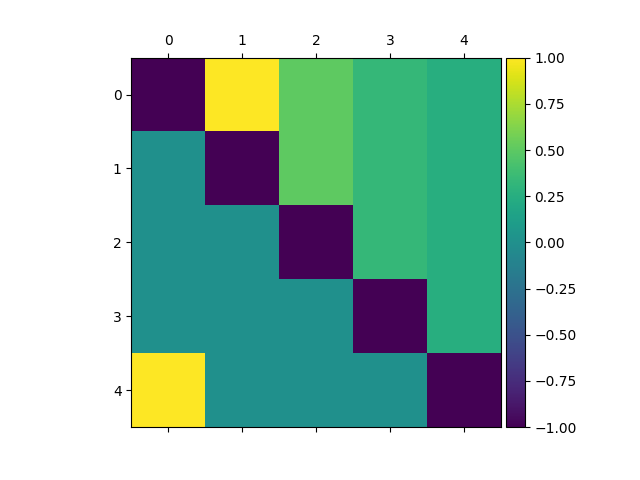

In [5]:
# test 1 : building a 'System' object

#%matplotlib inline

syst = System()
print(syst.dim)
print(syst.state)
print(syst.J_0)
print(syst.noisy)
print(syst.run)
syst.plotMatrix()

state at t=0 :  [1. 0. 0. 0. 0.]
state at t=1 :  [0. 0. 0. 0. 1.]
state at t=2 :  [0.25 0.25 0.25 0.25 0.  ]
state at t=3 :  [0.45833333 0.20833333 0.08333333 0.         0.25      ]
state at t=4 :  [0.3125     0.10416667 0.0625     0.0625     0.45833333]
.after reset :  [1. 0. 0. 0. 0.]
...after run :  [0.32432432 0.16216216 0.10810811 0.08108108 0.32432432]
state at t=4 :  [0.3125     0.10416667 0.0625     0.0625     0.45833333]


<IPython.core.display.Javascript object>


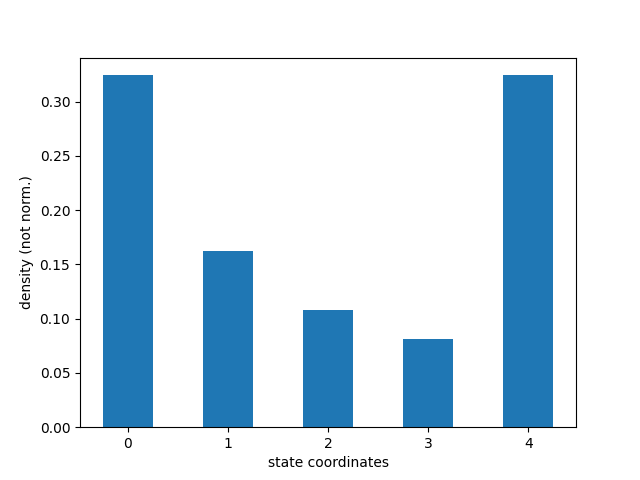

In [6]:
# test 2 : System.doStep(), System.reset(), System.run(), syst.plotState()

syst = System()
for i in range(5) :
    print('state at t=%i : '%i, syst.state)
    syst.doStep()
syst.reset()
print('.after reset : ', syst.state)
syst.run()
print('...after run : ', syst.state)
print('state at t=4 : ', syst.states[:,4])
syst.plotState()

<IPython.core.display.Javascript object>


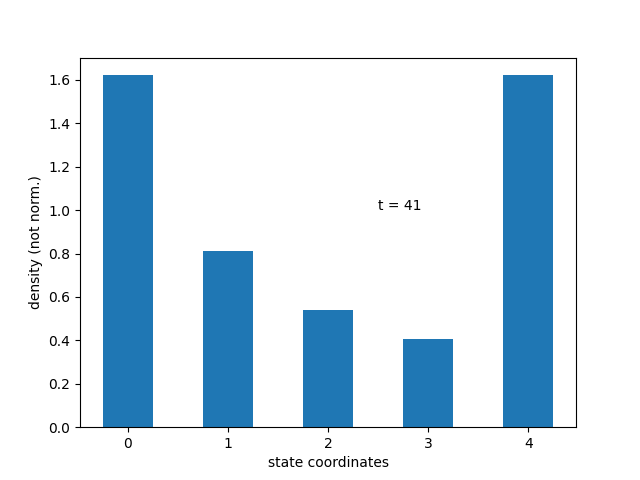

In [9]:
# test 3 : System.animateState()

#%matplotlib notebook

syst = System()
syst.run()
syst.animateState()

## To do :
- add the physical dimensions everyhere (top to bottom),
- sort-out the confusion between dimension/state/macrostate/microstate, as well as the confusion between particle/system/etc. In Boltzmann-Gibbs each dimension $i$ is a microstate for each particle, and a state $\mathbf{X}$ is a macrostate of the whole system. In SSR (or description in *General description*) a dimension $i$ is a macrostate and a state $\mathbf{X}$ is (yet) the probability distribution of the macrostates for a single particle (change SSR to many particles ??),
- ...

In [55]:
a = (1)
print(a)

1
